### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 1st at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (100 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $2000$ bootstrap realizations of this dataset. Using an appropriate timing function in python, how long did the generation of these realizations take? 
*DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together. This code will be graded on efficiency and speed; it should not take more than 1 second to execute.*

5) Repeat (2) with all $2000$ boostrap datasets to find the distribution of the sample mean. How long did this take? Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $2000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
# !pip install numdifftools

In [2]:
# import numdifftools as nd
# H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
# sigma_laplace = np.linalg.inv(H)**0.5

### Solution

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
import numdifftools as nd
import time
from random import choices
import corner

### Part 1

In [4]:
file = np.load("../../../homeworks/hw_data/hw3_data_1.npy") # SD: load in the file and get lists of data and uncertainty
data_list = [x[0] for x in file]
uncert_list = [x[1] for x in file]
mean_denominator= np.sum([1/(x**2) for x in uncert_list]) # SD: calculating mean and uncertainty acording to the lecture formulae
mean = np.sum([data_list[i]/(x**2) for i, x in enumerate(uncert_list)]/mean_denominator)
sigma = mean_denominator**(-1/2)
print(f"The mean is {mean}, and the uncertainty is {sigma}")

The mean is 4.082099776157916, and the uncertainty is 0.0937975025520293


### Part 2

In [5]:
def logL(guessed_mean, data, uncert):
    '''
    Function to calculate the log-likelihood.
    -------------------------
    Args
    ----------
    guessed_mean: the value of the guessed mean for which to calculate the log-likelihood
    data: data on which this guessed mean is based
    uncert: uncertainty on the data points
    ----------
    Returns
    ----------
    logL: log-likelihood
    '''
    z_squared = np.log(2*np.pi*(np.array(uncert)**2)) + ((data - guessed_mean)/uncert)**2
    return -0.5*np.sum(z_squared)

f_logL = lambda beta: -logL(beta, data_list, uncert_list) # SD: lambda function to feed into scipy's optimize function. -ve sign because scipy minimizes when optimizing and fit gets better with larger logL values.
bestfit_mean = optimize.fmin(f_logL, 4)[0]
print(f"The best fit mean is {bestfit_mean}")

Optimization terminated successfully.
         Current function value: 153.618547
         Iterations: 12
         Function evaluations: 24
The best fit mean is 4.082128906249999


### Part 3

In [6]:
H = nd.Hessian(f_logL)([bestfit_mean]) # SD: using the Hessian to calculate the second derivative
sigma_laplace = np.linalg.inv(H)**0.5
print(f"Fisher uncertainty estimate on the mean is {sigma_laplace[0][0]}")

Fisher uncertainty estimate on the mean is 0.09379750255202936


### Part 4

In [7]:
def bootstrap(data, n_realizations):
    '''
    Function to create n_realizations of the data using bootstrap method (random sampling with replacement).
    -------------------------
    Args
    ----------
    data: data from which points will be randomly sampled. each value in this data structure must be a tuple of (value, uncertainty) so that they remain paired correctly.
    n_realizations: number of realizations to create
    ----------
    Returns
    ----------
    bootstrapped_datasets: numpy array containing n bootstrapped realizations of the data.
    '''
    bootstrapped_datasets = []
    for i in range(n_realizations):
        bootstrapped_datasets.append(choices(np.array(data), k=len(data)))
    return np.array(bootstrapped_datasets) # SD: numpy arrays specifically to allow for things like dataset[:, i]. will be very useful for later parts 

start_time = time.time() # SD: measuring time taken to create 2000 bootstraps
datasets = bootstrap(file, 2000)
print(f"Time taken to run: {time.time()-start_time} seconds")

Time taken to run: 0.07398200035095215 seconds


### Part 5

Time taken to run: 0.6913731098175049 seconds


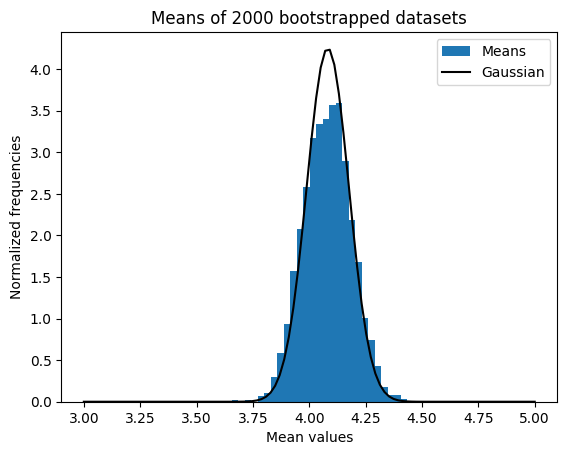

In [8]:
start_time = time.time()
means = []
for dataset in datasets: # SD: calculating best-fit mean for each bootstrapped dataset
    means.append(optimize.fmin(lambda beta: -logL(beta, dataset[:,0], dataset[:,1]), 4, disp=False)[0]) # SD: disp=False to make it stop printing out
print(f"Time taken to run: {time.time()-start_time} seconds")

plt.hist(means, bins="scott", density=True, label="Means") # SD: using Scott's Rule to calculate number of bins

distG = stats.norm(mean, sigma)
xgrid = np.linspace(3, 5, 100)
gaussPDF = distG.pdf(xgrid)
plt.plot(xgrid, gaussPDF, "k-", label="Gaussian")
plt.xlabel("Mean values")
plt.ylabel("Normalized frequencies")
plt.title("Means of 2000 bootstrapped datasets")
plt.legend()
plt.show()

The histogram and the Gaussian agree!

### Part 6

In [9]:
def logLaplacian(loc, scale, data):
    '''
    Function to calculate the log-laplacian.
    -------------------------
    Args
    ----------
    loc: parameter of the laplacian
    scale: parameter of the laplacian
    data: data on which we are calculating the log-laplacian
    ----------
    Returns
    ----------
    logLaplacian: the calculated log-laplacian
    '''
    return -len(data)*np.log(2*scale) - np.sum(np.abs(data-loc)/scale)

f_logLaplacian = lambda beta: -logLaplacian(beta[0], beta[1], data_list) # SD: -ve again because scipy's optimize function minimizes values
bestfit_laplacian = optimize.fmin(f_logLaplacian, (4, 1))
print(f"The best fits are: loc = {bestfit_laplacian[0]} and scale = {bestfit_laplacian[1]}")

Optimization terminated successfully.
         Current function value: 161.631942
         Iterations: 33
         Function evaluations: 62
The best fits are: loc = 4.091727637863617 and scale = 0.9260490221369678


### Part 7

In [10]:
def AIC(ML, k, N):
    '''
    Function to calculate the Akaike Information Criterion (AIC) of a model.
    -------------------------
    Args
    ----------
    ML: maximum value of the model (the value returned when the best-fit values are given to the model). example- log-likelihood
    k: number of parameters in model
    N: number of data points
    ----------
    Returns
    ----------
    AIC: the calculated Akaike Information Criterion for the model. the model with the lowest AIC value is favoured.
    '''
    return -2*ML + 2*k + (2*k*(k+1))/(N-k-1)

print(f"AIC of Gaussian is {AIC(logL(bestfit_mean, data_list, uncert_list), 1, len(data_list))}")
print(f"AIC of Laplacian is {AIC(logLaplacian(bestfit_laplacian[0], bestfit_laplacian[1], data_list), 2, len(data_list))}")

AIC of Gaussian is 309.27790940561624
AIC of Laplacian is 327.38759523959703


AIC of Gaussian fit is lower, meaning it is favoured over the Laplacian fit.

### Part 8

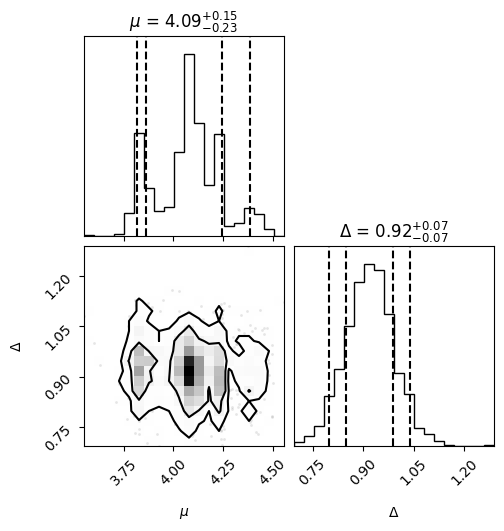

In [11]:
locs = []
scales = []
for dataset in datasets: # SD: calculating best-fit loc and scale for each bootstrapped dataset
    bestfits = optimize.fmin(lambda beta: -logLaplacian(beta[0], beta[1], dataset[:,0]), (4, 1), disp=False)
    locs.append(bestfits[0])
    scales.append(bestfits[1])
corner.corner(np.stack((locs, scales)).T, levels=(0.68, 0.95), title_quantiles=(0.16, 0.5, 0.84), quantiles=(0.05, 0.16, 0.84, 0.95), 
              show_titles=True, labels=[r"$\mu$", r"$\Delta$"]) # SD: corner plot!
plt.show()

### Part 9

In [12]:
H = nd.Hessian(f_logLaplacian)([bestfits[0], bestfits[1]])
sigma_laplace = np.linalg.inv(H)**0.5
print(f"Fisher uncertainty estimate for (loc, scale) is {np.diag(sigma_laplace)}")

Fisher uncertainty estimate for (loc, scale) is [0.11474541 0.08807171]


These are in the same approximate range as the uncertainties in the corner plot!